# Problem 1

### 1.

- **Case $i = j$:**

$\frac{\partial o_i}{\partial v_i} = \frac{\exp(v_i) \sum_{j=1}^{k} \exp(v_j) - \exp(v_i)\exp(v_i)}{\left(\sum_{j=1}^{k} \exp(v_j)\right)^2}$

$= \frac{\exp(v_i)}{\sum_{j=1}^{k} \exp(v_j)} \left(1 - \frac{\exp(v_i)}{\sum_{j=1}^{k} \exp(v_j)}\right)$

$= o_i (1 - o_i)$

- **Case $i \neq j$:**

$\frac{\partial o_i}{\partial v_j} = \frac{0 - \exp(v_i)\exp(v_j)}{\left(\sum_{j=1}^{k} \exp(v_j)\right)^2}$

$= -\frac{\exp(v_i)}{\sum_{j=1}^{k} \exp(v_j)} \cdot \frac{\exp(v_j)}{\sum_{j=1}^{k} \exp(v_j)}$

$= -o_i o_j$

### 2.

Given the cross-entropy loss:

$L = -\sum_{i=1}^{k} y_i \log(o_i)$

$\frac{\partial L}{\partial v_i} = -\sum_{i=1}^{k} y_i \frac{\partial \log(o_i)}{\partial v_i}$

$\frac{\partial L}{\partial v_i} = -\sum_{i=1}^{k} y_i \frac{1}{o_i} \frac{\partial o_i}{\partial v_i}$

We know that

- For $i = j$, we have $\frac{\partial o_i}{\partial v_i} = o_i (1 - o_i)$
- For $i \neq j$, we have $\frac{\partial o_i}{\partial v_j} = -o_i o_j$

Then we can get

$\frac{\partial L}{\partial v_i} = -y_i \frac{1}{o_i} o_i (1 - o_i) + \sum_{j \neq i} y_j \frac{1}{o_j} o_i o_j$

$= -y_i (1 - o_i) + \sum_{j \neq i} y_j o_i$

Since $y_i$ is a one-hot encoded vector, all $y_j = 0$ for $j \neq i$, and $y_i = 1$ for the correct class. Thus, the equation simplifies to:

$\frac{\partial L}{\partial v_i} = -(1 - o_i) + 0 = o_i - y_i $

# Problem 2

This notebook covers a Python-based solution for the fourth programming exercise of the machine learning class on Coursera.  Please refer to the [exercise text](https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex4.pdf) for detailed descriptions and equations.

For this exercise we'll again tackle the hand-written digits data set, this time using a feed-forward neural network with backpropagation.  We'll implement un-regularized and regularized versions of the neural network cost function and gradient computation via the backpropagation algorithm.  We'll also implement random weight initialization and a method to use the network to make predictions.

Since the data set is the same one we used in exercise 3, we'll re-use the code to load the data.

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = loadmat('/content/drive/MyDrive/ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

Since we're going to need these later (and will use them often), let's create some useful variables up-front.

In [34]:
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

We're also going to need to one-hot encode our y labels.  One-hot encoding turns a class label n (out of k classes) into a vector of length k where index n is "hot" (1) while the rest are zero.  Scikit-learn has a built in utility we can use for this.

In [35]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(5000, 10)

In [36]:
y[0], y_onehot[0,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

The neural network we're going to build for this exercise has an input layer matching the size of our instance data (400 + the bias unit), a hidden layer with 25 units (26 with the bias unit), and an output layer with 10 units corresponding to our one-hot encoding for the class labels.  For additional details and an image of the network architecture, please refer to the PDF in the "exercises" folder.

The first piece we need to implement is a cost function to evaluate the loss for a given set of network parameters.  The source mathematical function is in the exercise text (and looks pretty intimidating).  Here are the functions required to compute the cost.

In [37]:
def sigmoid(z):
    return 1 / (1 + np.exp(-2*z))

In [38]:
def forward_propagate(X, theta1, theta2, theta3):
    m = X.shape[0]

    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    a3 = np.insert(sigmoid(z3), 0, values=np.ones(m), axis=1)
    z4 = a3 * theta3.T
    h = sigmoid(z4)

    return a1, z2, a2, z3, a3, z4, h

In [39]:
def cost(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size_1 * (input_size + 1)], (hidden_size_1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1):hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1)], (hidden_size_2, (hidden_size_1 + 1))))
    theta3 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1):], (num_labels, (hidden_size_2 + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, a3, z4, h = forward_propagate(X, theta1, theta2, theta3)

    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    return J

We've used the sigmoid function before so that's not new.  The forward-propagate function computes the hypothesis for each training instance given the current parameters.  It's output shape should match the same of our one-hot encoding for y.  We can test this real quick to convince ourselves that it's working as expected (the intermediate steps are also returned as these will be useful later).

In [40]:
# initial setup
input_size = 400
hidden_size_1 = 20
hidden_size_2 = 20
num_labels = 10
learning_rate = 1

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1) + num_labels * (hidden_size_2 + 1)) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size_1 * (input_size + 1)], (hidden_size_1, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1):hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1)], (hidden_size_2, (hidden_size_1 + 1))))
theta3 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1):], (num_labels, (hidden_size_2 + 1))))

theta1.shape, theta2.shape, theta3.shape

((20, 401), (20, 21), (10, 21))

In [41]:
a1, z2, a2, z3, a3, z4, h = forward_propagate(X, theta1, theta2, theta3)
a1.shape, z2.shape, a2.shape, z3.shape, a3.shape, z4.shape, h.shape

((5000, 401),
 (5000, 20),
 (5000, 21),
 (5000, 20),
 (5000, 21),
 (5000, 10),
 (5000, 10))

The cost function, after computing the hypothesis matrix h, applies the cost equation to compute the total error between y and h.

In [42]:
cost(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y_onehot, learning_rate)

6.860472351751276

Our next step is to add regularization to the cost function.  If you're following along in the exercise text and thought the last equation looked ugly, this one looks REALLY ugly.  It's actually not as complicated as it looks though - in fact, the regularization term is simply an addition to the cost we already computed.  Here's the revised cost function.

In [43]:
def cost(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size_1 * (input_size + 1)], (hidden_size_1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1):hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1)], (hidden_size_2, (hidden_size_1 + 1))))
    theta3 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1):], (num_labels, (hidden_size_2 + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, a3, z4, h = forward_propagate(X, theta1, theta2, theta3)

    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)) + np.sum(np.power(theta3[:,1:], 2)))

    return J

In [44]:
cost(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y_onehot, learning_rate)

6.864959937436875

Next up is the backpropagation algorithm.  Backpropagation computes the parameter updates that will reduce the error of the network on the training data.  The first thing we need is a function that computes the gradient of the sigmoid function we created earlier.

In [45]:
def sigmoid_gradient(z):
    return 2 * np.multiply(sigmoid(z), (1 - sigmoid(z)))

Now we're ready to implement backpropagation to compute the gradients.  Since the computations required for backpropagation are a superset of those required in the cost function, we're actually going to extend the cost function to also perform backpropagation and return both the cost and the gradients.

In [50]:
def backprop(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size_1 * (input_size + 1)], (hidden_size_1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1):hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1)], (hidden_size_2, (hidden_size_1 + 1))))
    theta3 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1):], (num_labels, (hidden_size_2 + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, a3, z4, h = forward_propagate(X, theta1, theta2, theta3)

    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (100, 401)
    delta2 = np.zeros(theta2.shape)  # (25, 101)
    delta3 = np.zeros(theta3.shape)  # (10, 26)

    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)) + np.sum(np.power(theta3[:,1:], 2)))

    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 100)
        a2t = a2[t,:]  # (1, 101)
        z3t = z3[t,:]  # (1, 25)
        a3t = a3[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)

        d4t = ht - yt  # (1, 10)

        z3t = np.insert(z3t, 0, values=np.ones(1))
        d3t = np.multiply((theta3.T * d4t.T).T, sigmoid_gradient(z3t))

        z2t = np.insert(z2t, 0, values=np.ones(1))
        d2t = np.multiply((theta2.T * d3t[:,1:].T).T, sigmoid_gradient(z2t))

        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + (d3t[:,1:]).T * a2t
        delta3 = delta3 + d4t.T * a3t

    delta1 = delta1 / m
    delta2 = delta2 / m
    delta3 = delta3 / m

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2), np.ravel(delta3)))

    return J, grad

The hardest part of the backprop computation (other than understanding WHY we're doing all these calculations) is getting the matrix dimensions right.  By the way, if you find it confusing when to use A * B vs. np.multiply(A, B), you're not alone.  Basically the former is a matrix multiplication and the latter is an element-wise multiplication (unless A or B is a scalar value, in which case it doesn't matter).  I wish there was a more concise syntax for this (maybe there is and I'm just not aware of it).

Anyway, let's test it out to make sure the function returns what we're expecting it to.

In [47]:
J, grad = backprop(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(6.8648655626433674, (8650,))

We still have one more modification to make to the backprop function - adding regularization to the gradient calculations.  The final regularized version is below.

In [51]:
def backprop(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size_1 * (input_size + 1)], (hidden_size_1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1):hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1)], (hidden_size_2, (hidden_size_1 + 1))))
    theta3 = np.matrix(np.reshape(params[hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1):], (num_labels, (hidden_size_2 + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, a3, z4, h = forward_propagate(X, theta1, theta2, theta3)

    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (100, 401)
    delta2 = np.zeros(theta2.shape)  # (25, 101)
    delta3 = np.zeros(theta3.shape)  # (10, 26)

    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)) + np.sum(np.power(theta3[:,1:], 2)))

    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 100)
        a2t = a2[t,:]  # (1, 101)
        z3t = z3[t,:]  # (1, 25)
        a3t = a3[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)

        d4t = ht - yt  # (1, 10)

        z3t = np.insert(z3t, 0, values=np.ones(1))
        d3t = np.multiply((theta3.T * d4t.T).T, sigmoid_gradient(z3t))

        z2t = np.insert(z2t, 0, values=np.ones(1))
        d2t = np.multiply((theta2.T * d3t[:,1:].T).T, sigmoid_gradient(z2t))

        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + (d3t[:,1:]).T * a2t
        delta3 = delta3 + d4t.T * a3t

    delta1 = delta1 / m
    delta2 = delta2 / m
    delta3 = delta3 / m

    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    delta3[:,1:] = delta3[:,1:] + (theta3[:,1:] * learning_rate) / m

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2), np.ravel(delta3)))

    return J, grad

In [52]:
J, grad = backprop(params, input_size, hidden_size_1, hidden_size_2, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(6.864959937436875, (8650,))

We're finally ready to train our network and use it to make predictions.  This is roughly similar to the previous exercise with multi-class logistic regression.

In [53]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size_1, hidden_size_2, num_labels, X, y_onehot, learning_rate),
                method='TNC', jac=True, options={'maxiter': 250})
fmin

<ipython-input-53-c71453587540>:4: OptimizeWarning: Unknown solver options: maxiter
  fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size_1, hidden_size_2, num_labels, X, y_onehot, learning_rate),


 message: Linear search failed
 success: False
  status: 4
     fun: 0.09715088253060414
       x: [-1.128e-01  3.257e-05 ...  5.944e-01 -4.184e-01]
     nit: 55
     jac: [-5.278e-05  6.515e-09 ... -1.750e-06  1.963e-06]
    nfev: 1013

We put a bound on the number of iterations since the objective function is not likely to completely converge.  Our total cost has dropped below 0.5 though so that's a good indicator that the algorithm is working.  Let's use the parameters it found and forward-propagate them through the network to get some predictions.

In [54]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size_1 * (input_size + 1)], (hidden_size_1, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size_1 * (input_size + 1):hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1)], (hidden_size_2, (hidden_size_1 + 1))))
theta3 = np.matrix(np.reshape(fmin.x[hidden_size_1 * (input_size + 1) + hidden_size_2 * (hidden_size_1 + 1):], (num_labels, (hidden_size_2 + 1))))

a1, z2, a2, z3, a3, z3, h = forward_propagate(X, theta1, theta2, theta3)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]])

Finally we can compute the accuracy to see how well our trained network is doing.

In [55]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 100.0%


The model accuracy of the 3-layered neural network is higher than that of the 2-layered neural network.

# Problem 3

### 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal

In [2]:
# Load and preprocess the MNIST dataset
(x_train, y_train), _ = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255
y_train = to_categorical(y_train, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Define the model creation function
def create_model(n_hidden_layers, dim_layer, activation, initializer):
    model = Sequential()
    model.add(Dense(dim_layer, activation=activation, kernel_initializer=initializer, input_shape=(784,)))
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=initializer))
    model.add(Dense(10, activation='softmax'))
    return model

# Function to compute gradients
def get_gradients(model, x_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)
    return tape.gradient(loss, model.trainable_weights)

In [4]:
# Training parameters
batch_size = 128
n_hidden_layers = 5
dim_layer = 100
epochs = 1
sigmas = [0.05, 0.1, 0.2]
activations = ['tanh', 'sigmoid']

# Prepare data for training
x_batch = x_train[:batch_size]
y_batch = y_train[:batch_size]

In [5]:
# Collecting gradients for each sigma and activation function
all_gradients = {act: {str(sigma): [] for sigma in sigmas} for act in activations}

for activation in activations:
    for sigma in sigmas:
        # Create, compile and train the model
        initializer = RandomNormal(stddev=sigma)
        model = create_model(n_hidden_layers, dim_layer, activation, initializer)
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        model.fit(x_batch, y_batch, epochs=epochs, verbose=0)

        # Get gradients
        gradients = get_gradients(model, x_batch, y_batch)
        for layer_idx, grad in enumerate(gradients):
            all_gradients[activation][str(sigma)].append(np.abs(grad.numpy().flatten()))

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


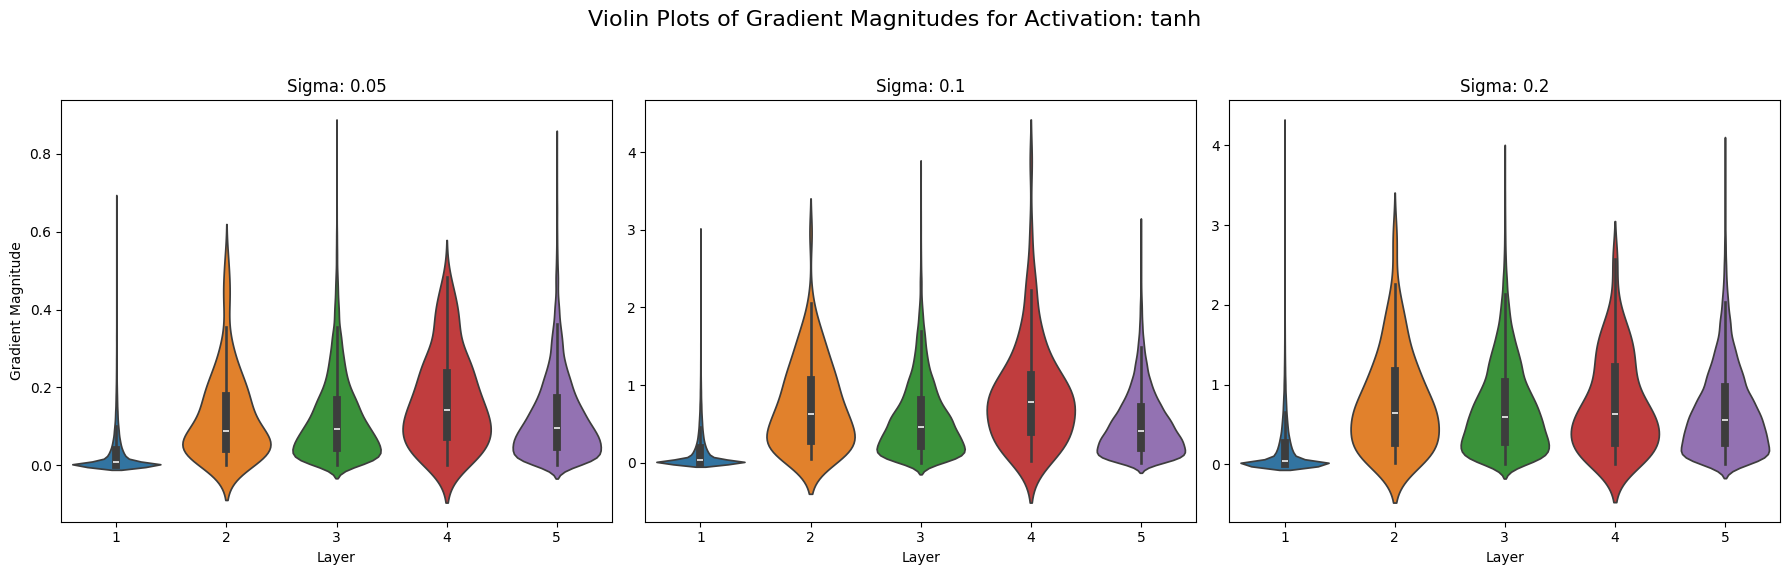

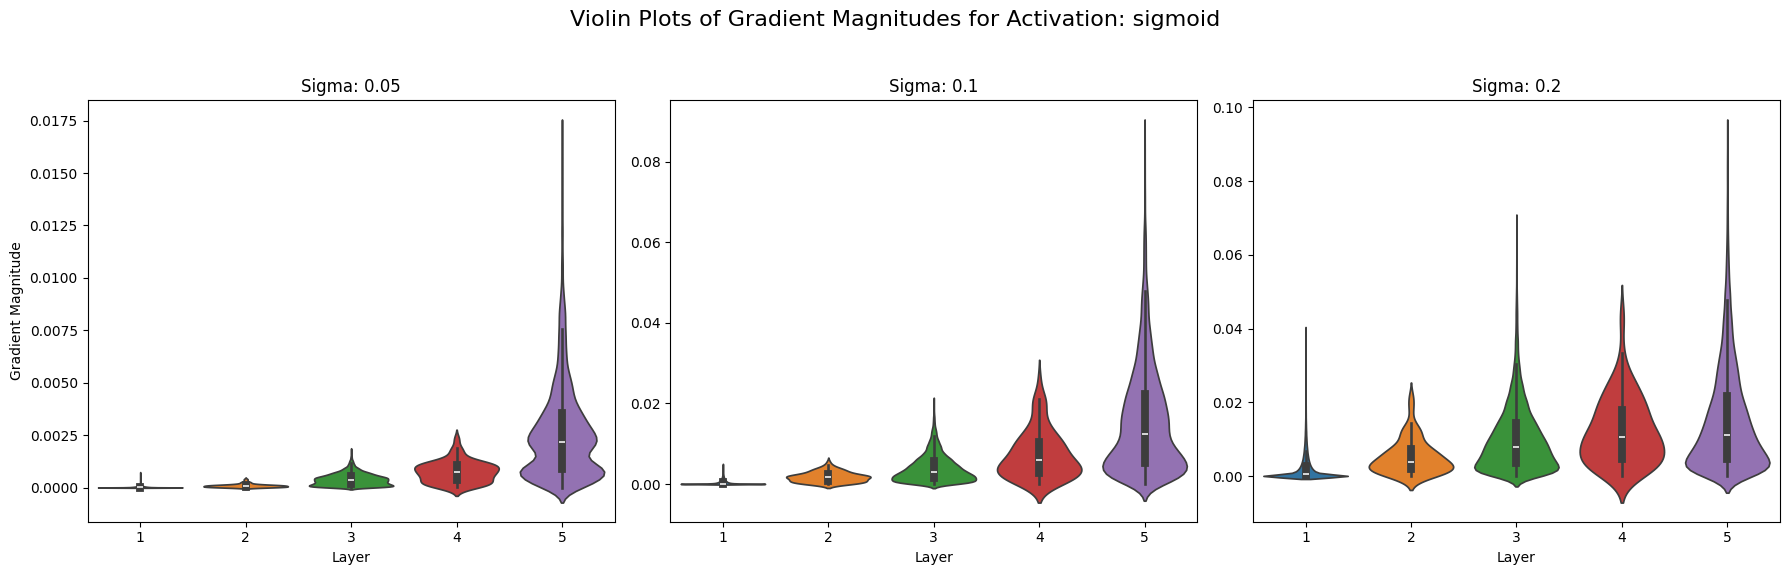

In [6]:
# Plotting gradients using violin plots
for activation in activations:
    plt.figure(figsize=(18, 6))
    plt.suptitle(f"Violin Plots of Gradient Magnitudes for Activation: {activation}", fontsize=16)
    for i, sigma in enumerate(sigmas):
        data_to_plot = [all_gradients[activation][str(sigma)][layer_idx] for layer_idx in range(n_hidden_layers)]
        plt.subplot(1, len(sigmas), i+1)
        sns.violinplot(data=data_to_plot)
        plt.title(f'Sigma: {sigma}')
        plt.xlabel('Layer')
        plt.ylabel('Gradient Magnitude' if i==0 else '')
        plt.xticks(ticks=range(n_hidden_layers), labels=range(1, n_hidden_layers+1))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Whatever the activation function is, the decrease of sigma means smaller gradients in the first and second layers. Especially for sigmoid activation function, when sigma 0.05 and 0.1, the vanishing gradient happens in the first two layers. In the first layer, the gradients are totally vanished.

### 2.

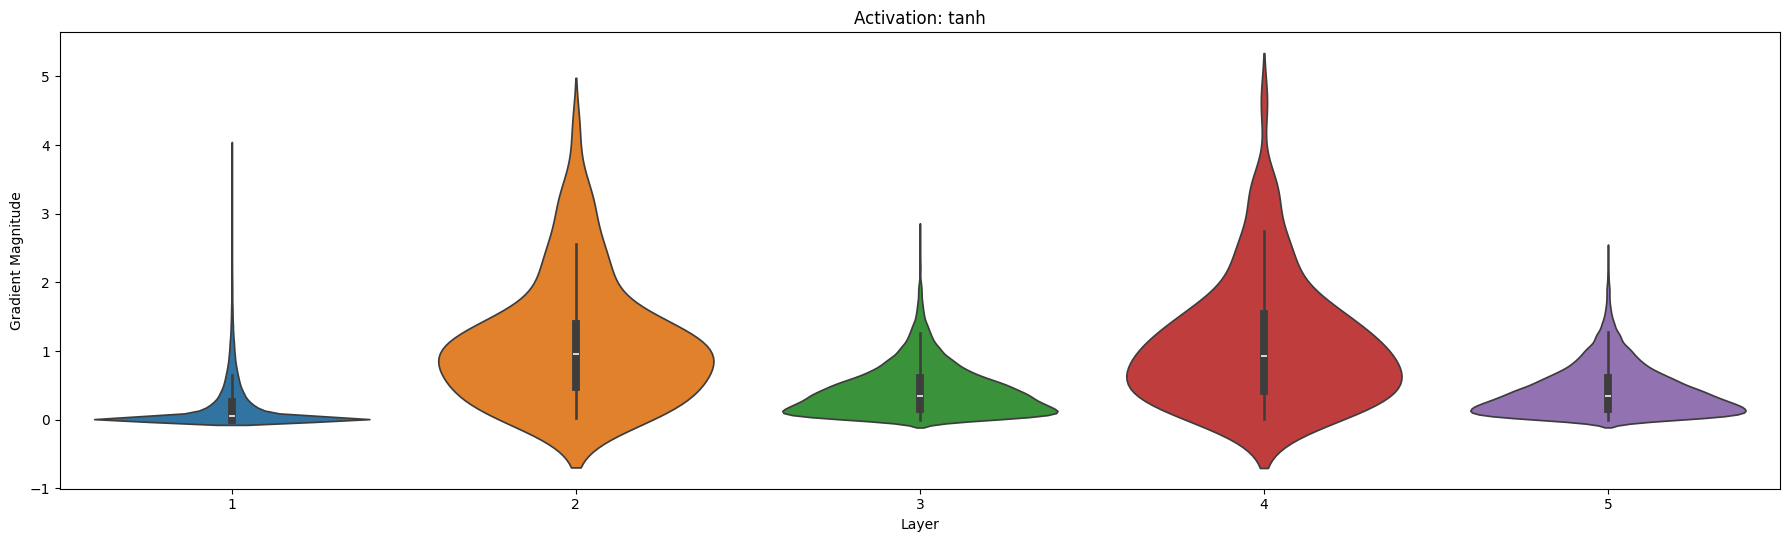

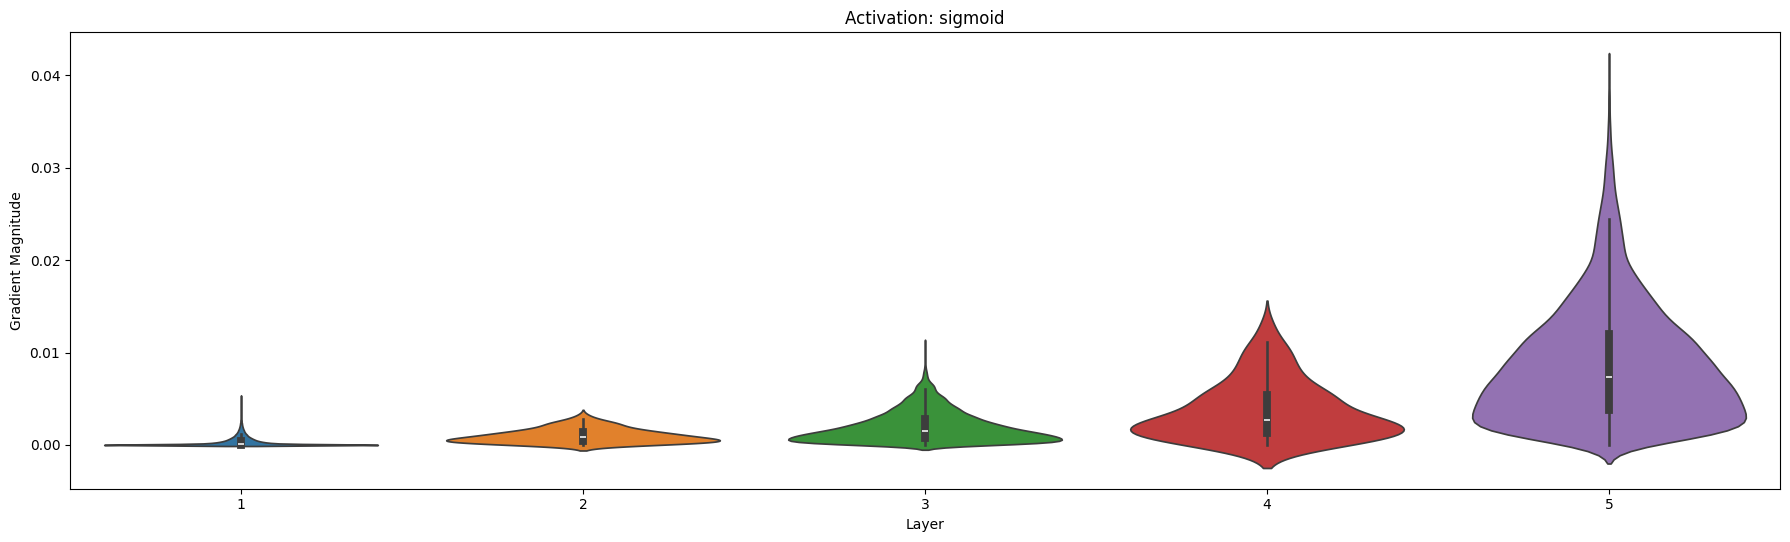

In [9]:
# Collecting gradients for each activation function
gradient_data = {act: [] for act in activations}

for activation in activations:
    # Create, compile and train the model
    model = create_model(n_hidden_layers, dim_layer, activation, 'glorot_normal')
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.fit(x_batch, y_batch, epochs=epochs, verbose=0)

    # Get gradients
    gradients = get_gradients(model, x_batch, y_batch)
    for layer_idx, grad in enumerate(gradients):
        gradient_data[activation].append(np.abs(grad.numpy().flatten()))

# Plotting gradients using violin plots
for activation in activations:
    plt.figure(figsize=(18, 6))
    data_to_plot = [gradient_data[activation][layer_idx] for layer_idx in range(n_hidden_layers)]
    sns.violinplot(data=data_to_plot)
    plt.title(f'Activation: {activation}')
    plt.xlabel('Layer')
    plt.ylabel('Gradient Magnitude')
    plt.xticks(ticks=range(n_hidden_layers), labels=range(1, n_hidden_layers+1))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Here, gradients are more similar along all the layers compared to the graph above.

### 3.

In [5]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
class NormalReLU(nn.Module):
    def __init__(self, input_size=1, hidden_size=2, num_hidden_layers=10, output_size=1):
        super().__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        # Dynamically add hidden layers
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [28]:
def simulation(model):
    x = np.random.uniform(-np.sqrt(7), np.sqrt(7), 3000)
    y = np.abs(x)

    x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)


    # Define the model
    model = model.to(device)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    batch_size = 64

    # Train the model for 1 epoch batch size 64
    for epoch in range(1):
        for i in range(0, len(x), 64):
            x_batch = x[i:i+64].to(device)
            y_batch = y[i:i+64].to(device)
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    x = x.clone().view(-1, 1).to(device)
    y_pred = model(x).detach().cpu().numpy()
    return np.std(y_pred)

In [29]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
result = []
for _ in tqdm(range(1000)):
    result.append(simulation(model=NormalReLU()))

cpu


100%|██████████| 1000/1000 [02:58<00:00,  5.62it/s]


In [59]:
result = np.array(result)
collapse_rate = np.sum(result == 0) / len(result)

In [56]:
collapse_rate

0.896

The result is pretty close to the 90 percent.

### 4.

In [43]:
class LeakyReLU(nn.Module):
    def __init__(self, input_size=1, hidden_size=2, num_hidden_layers=10, output_size=1):
        super().__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        # Dynamically add hidden layers
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.LeakyReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [44]:
leaky_result = []
for _ in tqdm(range(1000)):
    leaky_result.append(simulation(model=LeakyReLU()))

100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


In [58]:
leaky_result = np.array(leaky_result)
collapse_rate = np.sum(leaky_result == 0) / len(result)
collapse_rate

0.195

The leaky ReLu help significantly reduce the collapse rate. A potential reason may be that when $z < 0$, the activation is no longer zero, which significantly decreases the collapse rate.

# Problem 4

### 1.

Co-adaptation refers to a phenomenon in deep learning where different parts of the model (usually neurons in a neural network) become overly dependent on each other's specific behavior for making predictions. This situation can lead to reduced generalization capability because the model may not perform well on unseen data. The neurons effectively "co-adapt" to the peculiarities of the training data, making them less able to independently contribute to the correct output for new data instances.

Internal Covariate Shift refers to the problem in training deep neural networks where the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This can slow down the training process because the layers constantly need to adapt to new data distributions. It can make it difficult to set the learning rate and initialize the weights of the network in a way that is conducive to efficient learning across all layers.

### 2 & 3.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class LeNet5_BN(nn.Module):
    def __init__(self, batch_norm_input=False):
        super(LeNet5_BN, self).__init__()
        self.batch_norm_input = batch_norm_input

        # Optionally apply batch normalization to the input layer
        if self.batch_norm_input:
            self.bn_input = nn.BatchNorm2d(1)

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        if self.batch_norm_input:
            x = self.bn_input(x)
        x = self.bn1(torch.relu(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = self.bn2(torch.relu(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = self.bn3(torch.relu(self.fc1(x)))
        x = self.bn4(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, train_loader, test_loader, epochs=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Device is {device}')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_acc, test_acc, train_losses, test_losses = [], [], [], []
    for epoch in range(epochs):
        model.train()
        train_total = 0
        train_correct = 0
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            _, train_predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (train_predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            train_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{epochs} completed.')
        train_acc.append(100 * train_correct / train_total)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Evaluate model
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            test_loss = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.cpu().detach().numpy()

        print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')
        test_acc.append(100 * correct / total)
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
    return model, train_acc, test_acc, train_losses, test_losses


In [ ]:
# When using standard normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing the dataset to [-1, 1]
])

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [ ]:
model = LeNet5_BN()

In [ ]:
model, train_acc, test_acc, train_losses, test_losses = train_model(model, trainloader, testloader)

Device is cuda
Epoch 1/10 completed.
Accuracy of the model on the 10000 test images: 98.54%
Epoch 2/10 completed.
Accuracy of the model on the 10000 test images: 98.88%
Epoch 3/10 completed.
Accuracy of the model on the 10000 test images: 99.01%
Epoch 4/10 completed.
Accuracy of the model on the 10000 test images: 98.94%
Epoch 5/10 completed.
Accuracy of the model on the 10000 test images: 99.07%
Epoch 6/10 completed.
Accuracy of the model on the 10000 test images: 99.15%
Epoch 7/10 completed.
Accuracy of the model on the 10000 test images: 99.06%
Epoch 8/10 completed.
Accuracy of the model on the 10000 test images: 99.12%
Epoch 9/10 completed.
Accuracy of the model on the 10000 test images: 99.08%
Epoch 10/10 completed.
Accuracy of the model on the 10000 test images: 99.12%


In [ ]:
# Extract Batch Normalization Parameters
bn_layers = [model.bn1, model.bn2, model.bn3, model.bn4]
bn_params = {
    'means': [],
    'vars': [],
    'gammas': [],
    'betas': []
}

for layer in bn_layers:
    bn_params['means'].append(layer.running_mean.cpu().detach().numpy())
    bn_params['vars'].append(layer.running_var.cpu().detach().numpy())
    bn_params['gammas'].append(layer.weight.cpu().detach().numpy())
    bn_params['betas'].append(layer.bias.cpu().detach().numpy())

# Proceed to plotting in the next step
bn_params

{'means': [array([0.3521259 , 0.08060793, 0.19574112, 0.9182347 , 0.1645194 ,
         0.12612769], dtype=float32),
  array([1.3504919 , 0.34673256, 1.095709  , 0.54331845, 0.40891275,
         0.9069096 , 0.6373191 , 0.6107965 , 0.852872  , 0.65984756,
         0.9741115 , 0.5244455 , 0.4705577 , 0.6532327 , 0.6622317 ,
         0.6503085 ], dtype=float32),
  array([4.94896203e-01, 3.08464736e-01, 9.22855377e-01, 2.33910218e-01,
         4.75881904e-01, 3.62828225e-02, 2.65929222e-01, 3.96580815e-01,
         3.13816965e-01, 7.95026839e-01, 9.64653134e-01, 1.28475085e-06,
         5.10282278e-01, 1.08156002e+00, 3.21445227e-01, 4.58094358e-01,
         5.89628756e-01, 1.60513711e+00, 1.05166399e+00, 1.08473849e+00,
         4.89388466e-01, 6.57634556e-01, 2.57156909e-01, 1.02955706e-01,
         1.17513172e-01, 3.66469920e-02, 6.11515164e-01, 6.01726651e-01,
         6.56219840e-01, 2.18551591e-01, 7.11174786e-01, 3.69768471e-01,
         4.42776889e-01, 9.62472975e-01, 2.72807658e-01

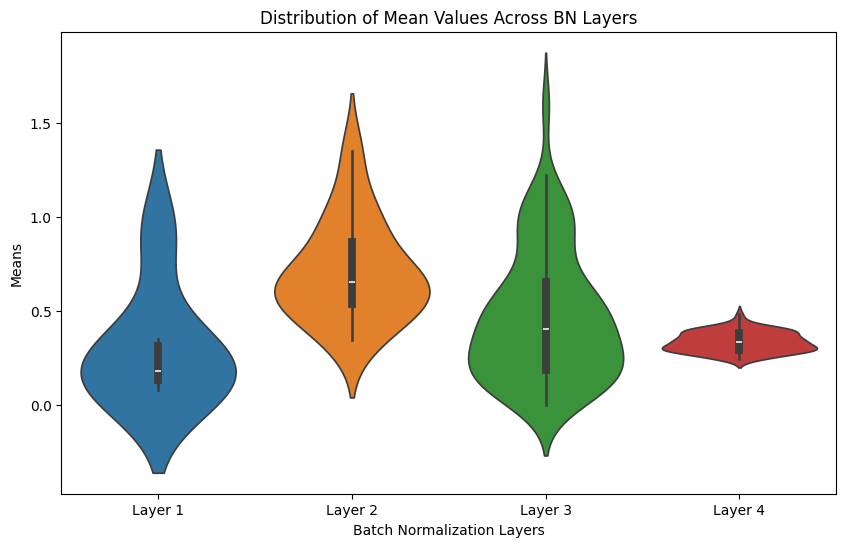

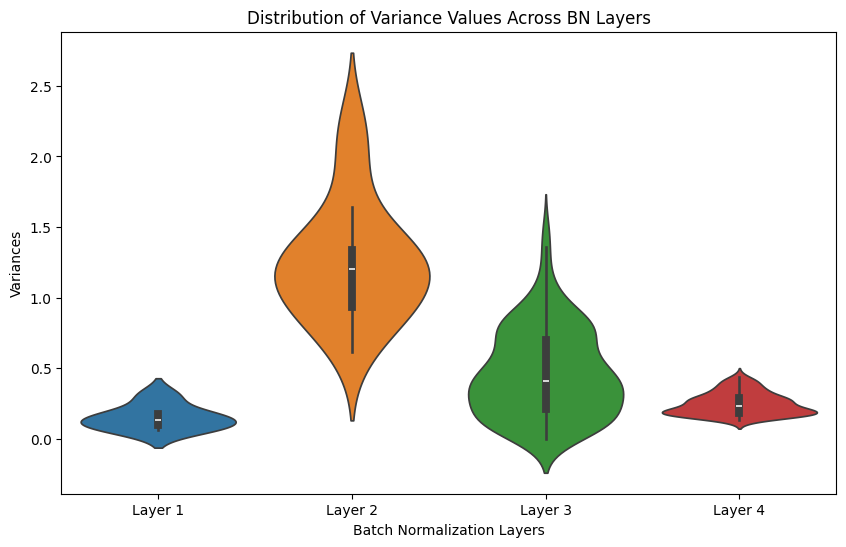

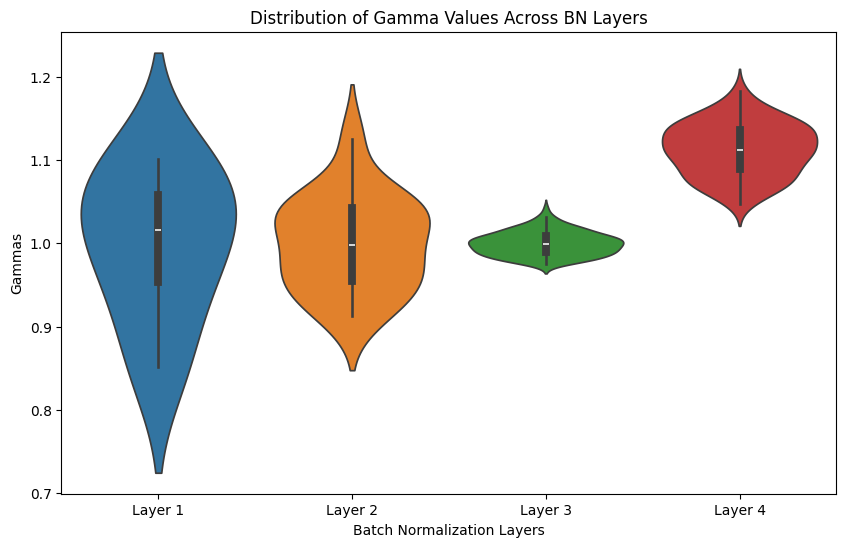

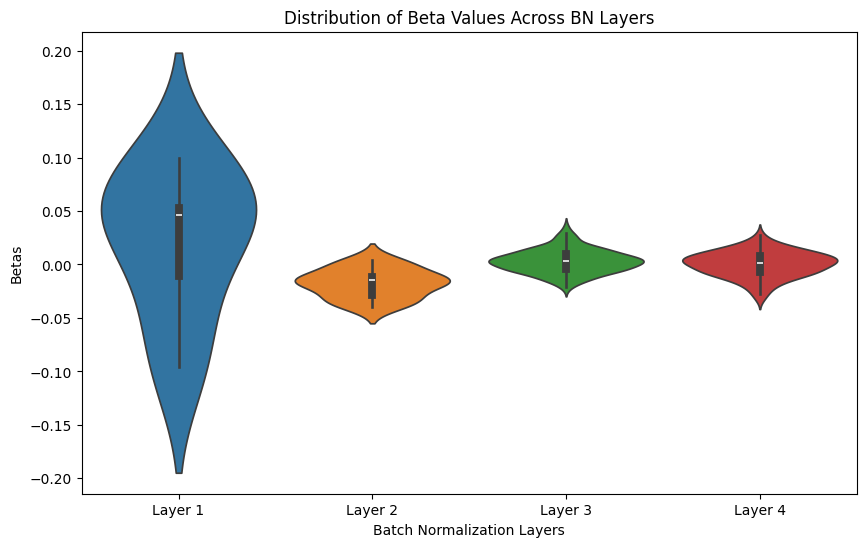

In [ ]:
# Data Visualization with Violin Plots

def plot_violin(data, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Batch Normalization Layers')
    plt.xticks(ticks=range(len(data)), labels=[f'Layer {i+1}' for i in range(len(data))])
    plt.show()

def plot_violins(bn_params):
    # Plotting the distribution of means
    plot_violin(bn_params['means'], 'Distribution of Mean Values Across BN Layers', 'Means')

    # Plotting the distribution of variances
    plot_violin(bn_params['vars'], 'Distribution of Variance Values Across BN Layers', 'Variances')

    # Plotting the distribution of gammas (scale parameters)
    plot_violin(bn_params['gammas'], 'Distribution of Gamma Values Across BN Layers', 'Gammas')

    # Plotting the distribution of betas (shift parameters)
    plot_violin(bn_params['betas'], 'Distribution of Beta Values Across BN Layers', 'Betas')

plot_violins(bn_params)

In [ ]:
BN_model = LeNet5_BN(batch_norm_input=True)

BN_transform = transforms.Compose([
    transforms.ToTensor()
])

BN_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=BN_transform)
BN_trainloader = torch.utils.data.DataLoader(BN_trainset, batch_size=128, shuffle=True)

BN_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=BN_transform)
BN_testloader = torch.utils.data.DataLoader(BN_testset, batch_size=128, shuffle=False)

In [ ]:
BN_model, BN_train_acc, BN_test_acc, BN_train_losses, BN_test_losses = train_model(BN_model, BN_trainloader, BN_testloader)

Device is cuda
Epoch 1/10 completed.
Accuracy of the model on the 10000 test images: 98.8%
Epoch 2/10 completed.
Accuracy of the model on the 10000 test images: 98.94%
Epoch 3/10 completed.
Accuracy of the model on the 10000 test images: 98.95%
Epoch 4/10 completed.
Accuracy of the model on the 10000 test images: 99.01%
Epoch 5/10 completed.
Accuracy of the model on the 10000 test images: 98.97%
Epoch 6/10 completed.
Accuracy of the model on the 10000 test images: 98.97%
Epoch 7/10 completed.
Accuracy of the model on the 10000 test images: 98.95%
Epoch 8/10 completed.
Accuracy of the model on the 10000 test images: 99.04%
Epoch 9/10 completed.
Accuracy of the model on the 10000 test images: 98.99%
Epoch 10/10 completed.
Accuracy of the model on the 10000 test images: 99.04%


In [ ]:
# Extract Batch Normalization Parameters
bn_layers = [BN_model.bn_input, BN_model.bn1, BN_model.bn2, BN_model.bn3, BN_model.bn4]
bn_params = {
    'means': [],
    'vars': [],
    'gammas': [],
    'betas': []
}

for layer in bn_layers:
    bn_params['means'].append(layer.running_mean.cpu().detach().numpy())
    bn_params['vars'].append(layer.running_var.cpu().detach().numpy())
    bn_params['gammas'].append(layer.weight.cpu().detach().numpy())
    bn_params['betas'].append(layer.bias.cpu().detach().numpy())

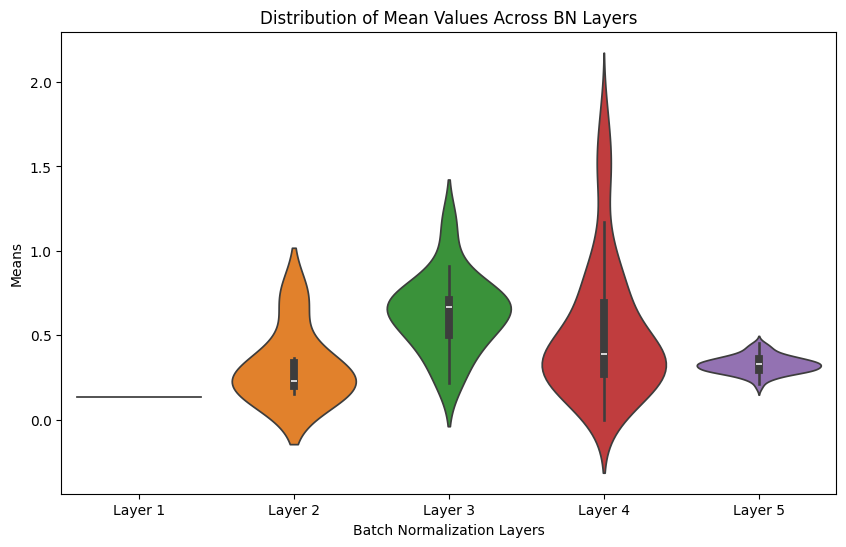

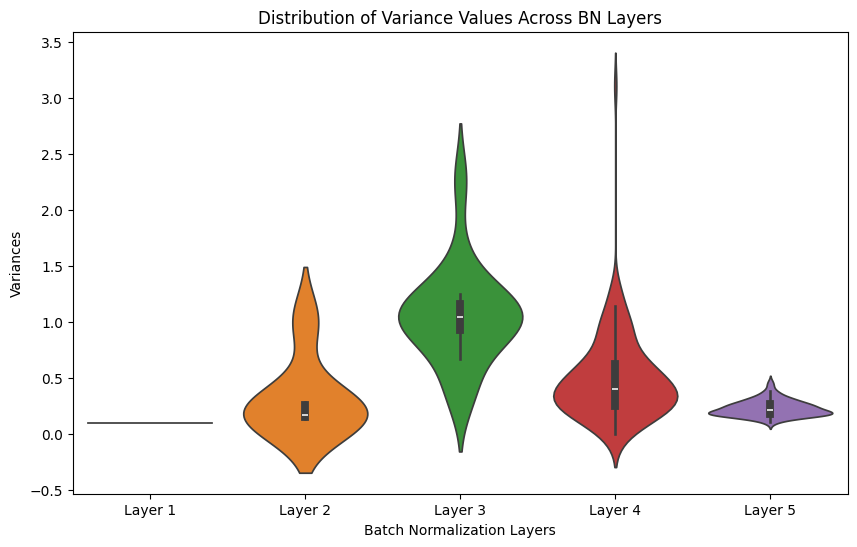

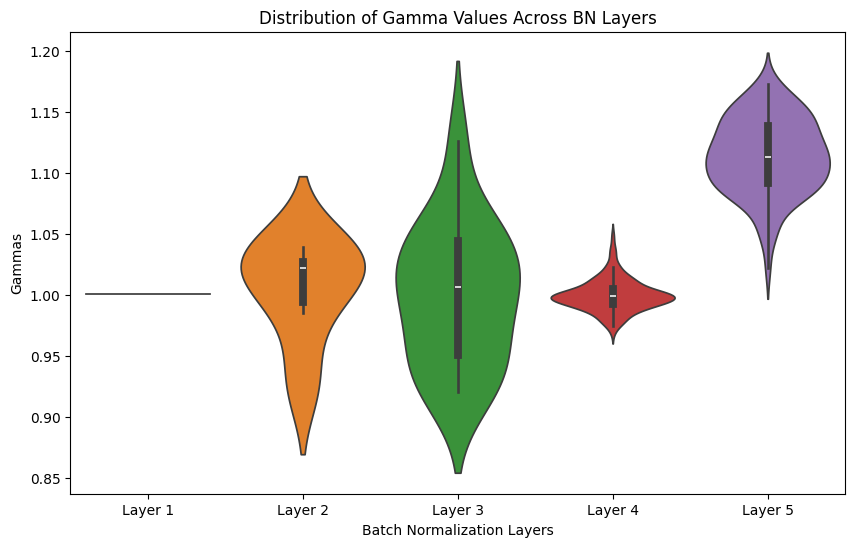

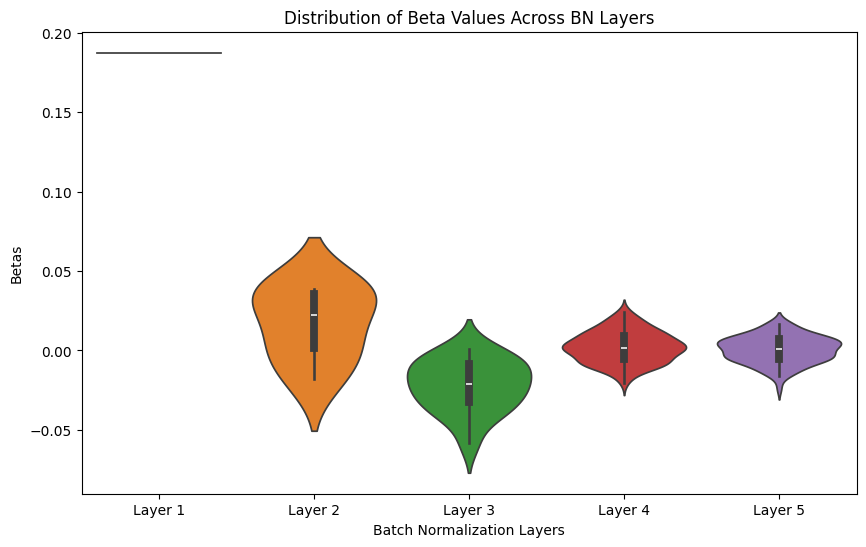

In [ ]:
plot_violins(bn_params)

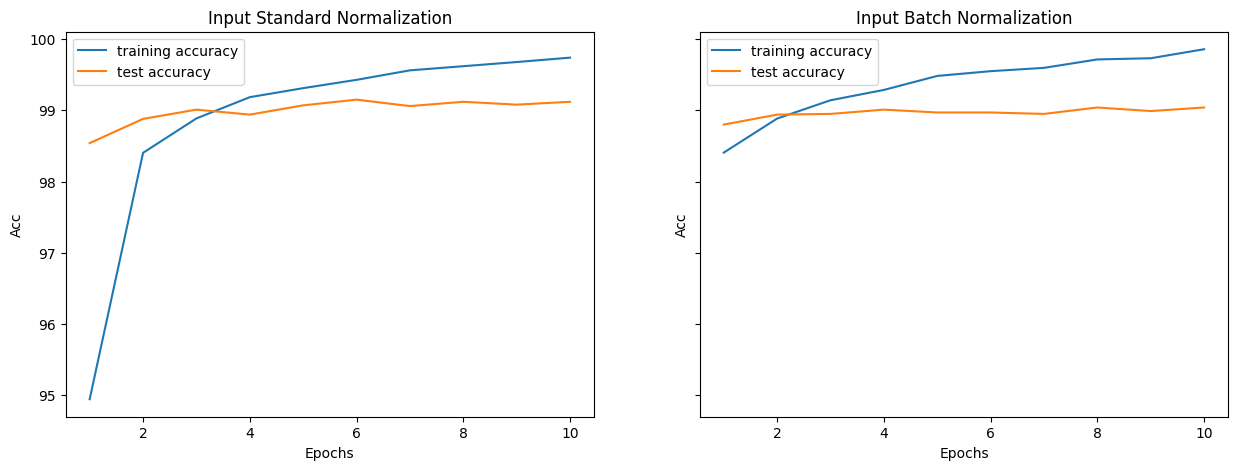

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

x = [i for i in range(1, 11)]
axs[0].plot(x, train_acc, label='training accuracy')
axs[0].plot(x, test_acc, label='test accuracy')
axs[0].set_title('Input Standard Normalization')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acc')
axs[0].legend()

axs[1].plot(x, BN_train_acc, label='training accuracy')
axs[1].plot(x, BN_test_acc, label='test accuracy')
axs[1].set_title('Input Batch Normalization')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Acc')
axs[1].legend()

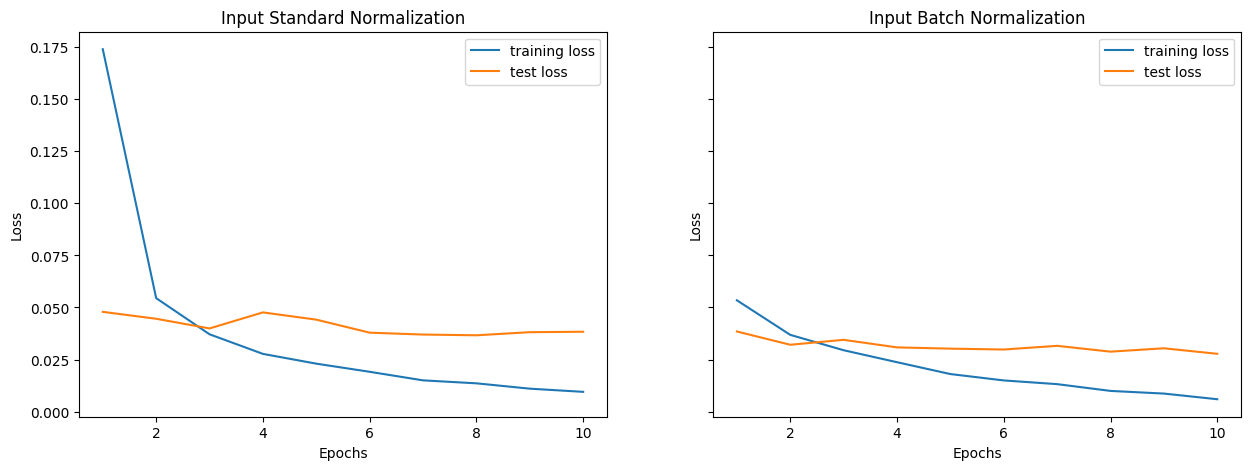

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

x = [i for i in range(1, 11)]
axs[0].plot(x, train_losses, label='training loss')
axs[0].plot(x, test_losses, label='test loss')
axs[0].set_title('Input Standard Normalization')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(x, BN_train_losses, label='training loss')
axs[1].plot(x, BN_test_losses, label='test loss')
axs[1].set_title('Input Batch Normalization')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

Observations:


The general trend of training and test loss, and training and test accuracy are almost the same for standard normalization and input batch normalization. Input batch normalization doesn't help improve performance.

### 4.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5_Dropout(nn.Module):
    def __init__(self, use_bn=False):
        super(LeNet5_Dropout, self).__init__()
        self.use_bn = use_bn
        self.bn_input = nn.BatchNorm2d(1) if use_bn else nn.Identity()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6) if use_bn else nn.Identity()
        self.dropout1 = nn.Dropout(p=0.2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16) if use_bn else nn.Identity()
        self.dropout2 = nn.Dropout(p=0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(16*4*4, 120)  # Adjust for the input size accordingly
        self.bn3 = nn.BatchNorm1d(120) if use_bn else nn.Identity()
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84) if use_bn else nn.Identity()
        self.dropout4 = nn.Dropout(p=0.5)

        # Output layer
        self.fc3 = nn.Linear(84, 10)  # Assuming 10 output classes

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.conv1(x))))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(F.relu(self.bn2(self.conv2(x))))
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 16*4*4)
        x = self.dropout3(F.relu(self.bn3(self.fc1(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc2(x))))

        x = self.fc3(x)
        return x


In [ ]:
# Load MNIST dataset
DO_transform = transforms.Compose([
    transforms.ToTensor()
])

DO_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=DO_transform)
DO_trainloader = torch.utils.data.DataLoader(DO_trainset, batch_size=128, shuffle=True)

DO_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=DO_transform)
DO_testloader = torch.utils.data.DataLoader(DO_trainset, batch_size=128, shuffle=False)

In [ ]:
dropout_model = LeNet5_Dropout()

In [ ]:
dropout_model, dropout_train_acc, dropout_test_acc, dropout_train_losses, dropout_test_losses = train_model(dropout_model, DO_trainloader, DO_testloader)

Device is cuda
Epoch 1/10 completed.
Accuracy of the model on the 10000 test images: 94.5%
Epoch 2/10 completed.
Accuracy of the model on the 10000 test images: 96.51166666666667%
Epoch 3/10 completed.
Accuracy of the model on the 10000 test images: 97.44666666666667%
Epoch 4/10 completed.
Accuracy of the model on the 10000 test images: 97.895%
Epoch 5/10 completed.
Accuracy of the model on the 10000 test images: 98.23%
Epoch 6/10 completed.
Accuracy of the model on the 10000 test images: 98.28166666666667%
Epoch 7/10 completed.
Accuracy of the model on the 10000 test images: 98.4%
Epoch 8/10 completed.
Accuracy of the model on the 10000 test images: 98.67666666666666%
Epoch 9/10 completed.
Accuracy of the model on the 10000 test images: 98.73%
Epoch 10/10 completed.
Accuracy of the model on the 10000 test images: 98.76166666666667%


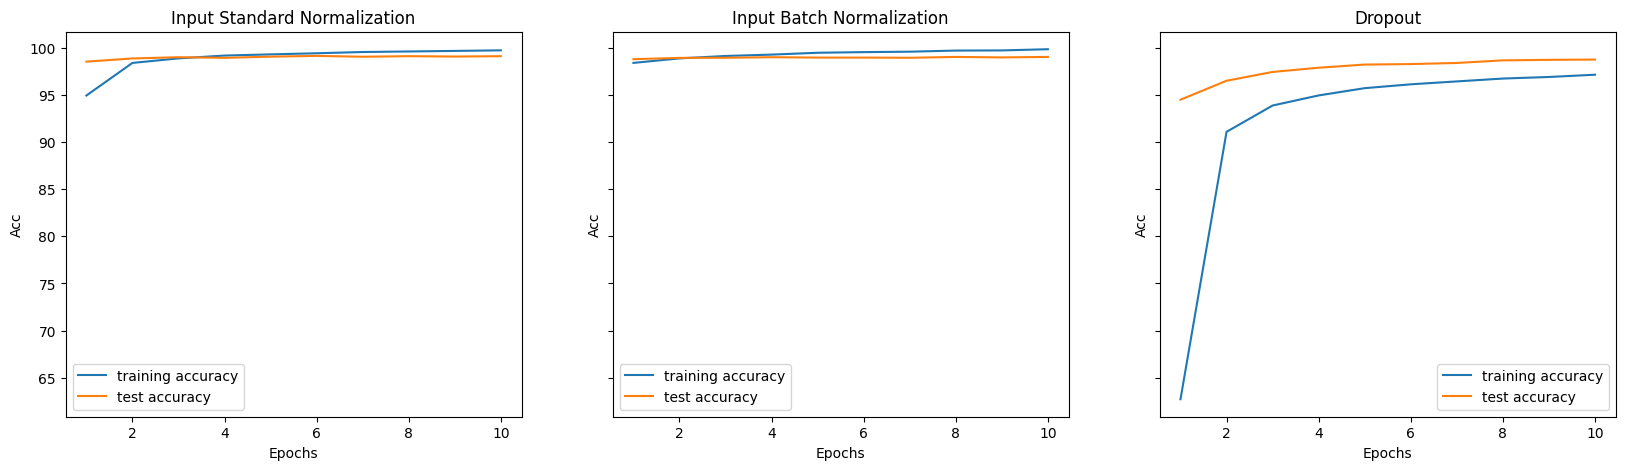

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

x = [i for i in range(1, 11)]
axs[0].plot(x, train_acc, label='training accuracy')
axs[0].plot(x, test_acc, label='test accuracy')
axs[0].set_title('Input Standard Normalization')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acc')
axs[0].legend()

axs[1].plot(x, BN_train_acc, label='training accuracy')
axs[1].plot(x, BN_test_acc, label='test accuracy')
axs[1].set_title('Input Batch Normalization')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Acc')
axs[1].legend()

axs[2].plot(x, dropout_train_acc, label='training accuracy')
axs[2].plot(x, dropout_test_acc, label='test accuracy')
axs[2].set_title('Dropout')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Acc')
axs[2].legend()

Observations:

For dropout LeNet model, the training accuracy is significantly lower than the case without dropout, while the test accuracy is very close, which shows that dropout prevents overfitting.

### 5.

In [ ]:
dropout_bn_model = LeNet5_Dropout(use_bn=True)

In [ ]:
dropout_bn_model, dropout_bn_train_acc, dropout_bn_test_acc, dropout_bn_train_losses, dropout_bn_test_losses = train_model(dropout_bn_model, DO_trainloader, DO_testloader)

Device is cuda
Epoch 1/10 completed.
Accuracy of the model on the 10000 test images: 93.95166666666667%
Epoch 2/10 completed.
Accuracy of the model on the 10000 test images: 96.62166666666667%
Epoch 3/10 completed.
Accuracy of the model on the 10000 test images: 97.21333333333334%
Epoch 4/10 completed.
Accuracy of the model on the 10000 test images: 97.68333333333334%
Epoch 5/10 completed.
Accuracy of the model on the 10000 test images: 97.80833333333334%
Epoch 6/10 completed.
Accuracy of the model on the 10000 test images: 98.14333333333333%
Epoch 7/10 completed.
Accuracy of the model on the 10000 test images: 97.48833333333333%
Epoch 8/10 completed.
Accuracy of the model on the 10000 test images: 98.31166666666667%
Epoch 9/10 completed.
Accuracy of the model on the 10000 test images: 98.335%
Epoch 10/10 completed.
Accuracy of the model on the 10000 test images: 98.01166666666667%


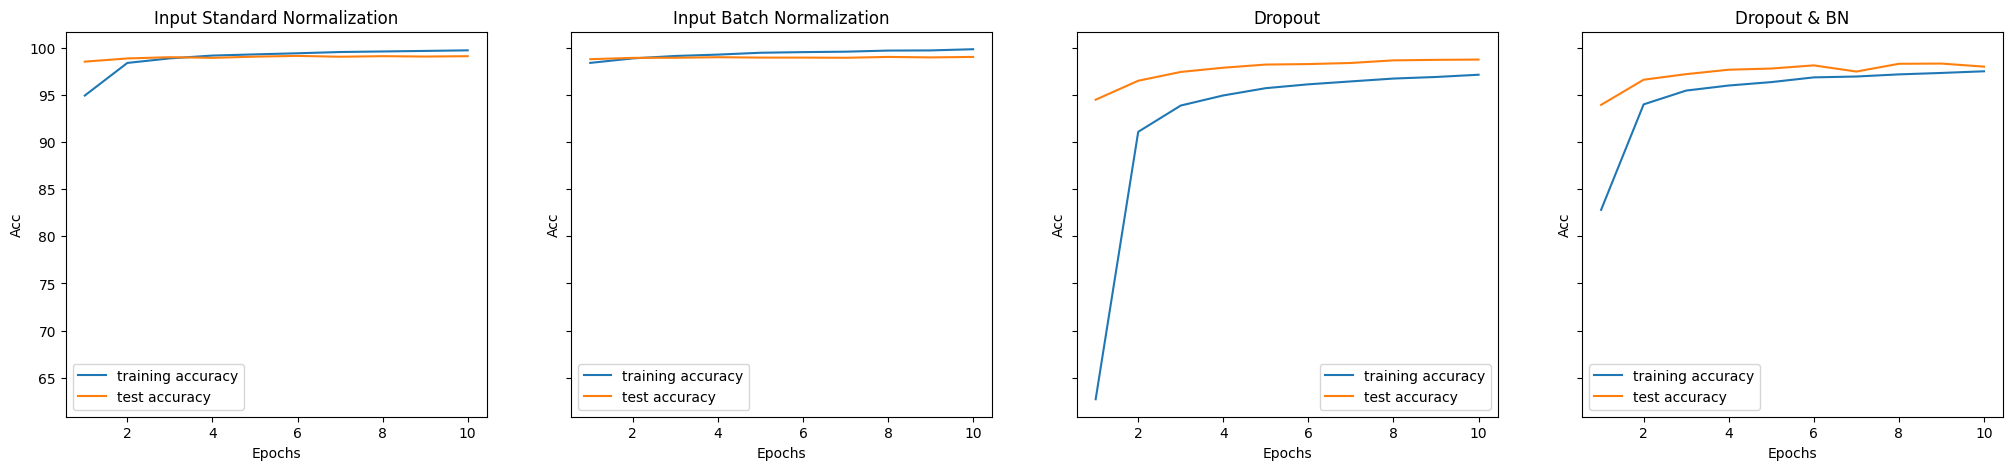

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(25, 5), sharey=True)

x = [i for i in range(1, 11)]
axs[0].plot(x, train_acc, label='training accuracy')
axs[0].plot(x, test_acc, label='test accuracy')
axs[0].set_title('Input Standard Normalization')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acc')
axs[0].legend()

axs[1].plot(x, BN_train_acc, label='training accuracy')
axs[1].plot(x, BN_test_acc, label='test accuracy')
axs[1].set_title('Input Batch Normalization')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Acc')
axs[1].legend()

axs[2].plot(x, dropout_train_acc, label='training accuracy')
axs[2].plot(x, dropout_test_acc, label='test accuracy')
axs[2].set_title('Dropout')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Acc')
axs[2].legend()

axs[3].plot(x, dropout_bn_train_acc, label='training accuracy')
axs[3].plot(x, dropout_bn_test_acc, label='test accuracy')
axs[3].set_title('Dropout & BN')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Acc')
axs[3].legend()

The training accuracy of Dropout & BN is better than only Dropout, and the test accuracy doesn't have large variations.

# Problem 5.

### 1.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data transformation
transform = transforms.Compose([transforms.ToTensor()])

# Loading the dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 12006740.35it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203387.88it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3768849.72it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7686819.86it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VanillaLeNet5(nn.Module):
    def __init__(self):
        super(VanillaLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
import torch.optim as optim
import torch.nn as nn

learning_rates = [10**(-9 + i) for i in range(11)]
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device is {device}')
model = VanillaLeNet5().to(device) # Adjust based on your implementation

for lr in learning_rates:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0

    for epoch in range(5):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Learning Rate: {lr}, Average Loss: {avg_loss}")


Device is cuda
Learning Rate: 1e-09, Average Loss: 11.52590472840551
Learning Rate: 1e-08, Average Loss: 11.525901696321045
Learning Rate: 1e-07, Average Loss: 11.525897875269338
Learning Rate: 1e-06, Average Loss: 11.525863897317508
Learning Rate: 1e-05, Average Loss: 11.525741794978632
Learning Rate: 0.0001, Average Loss: 11.524240366177263
Learning Rate: 0.001, Average Loss: 11.513120788501016
Learning Rate: 0.01, Average Loss: 5.661247232353001
Learning Rate: 0.1, Average Loss: 2.381320940628489
Learning Rate: 1, Average Loss: 28.508461642017497
Learning Rate: 10, Average Loss: 11.905122743740773


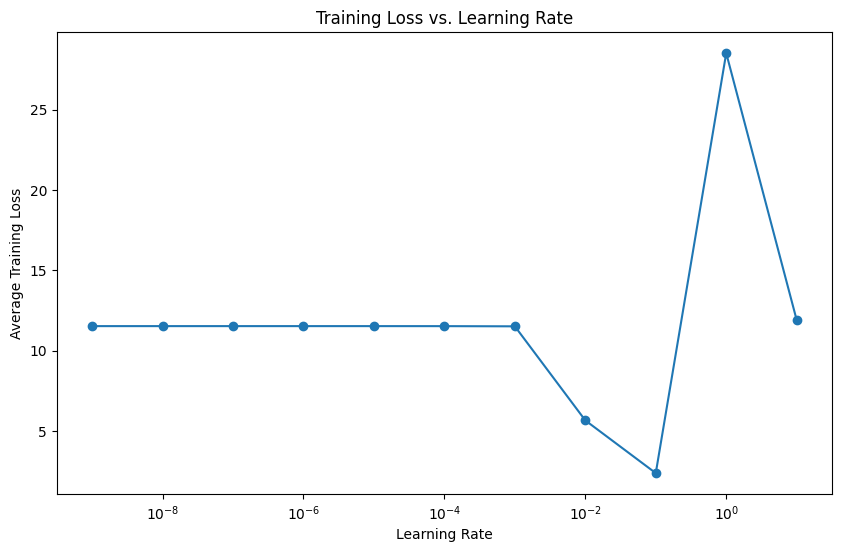

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(learning_rates, losses, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Average Training Loss')
plt.title('Training Loss vs. Learning Rate')
plt.show()

Here, $lr_{min} = 10^{-3}$ and $lr_{max} = 10^{-1}$

### 2.

In [ ]:
MIN_LR = 1e-3
MAX_LR = 1e-1
BATCH_SIZE = 64
STEP_SIZE = 8
NUM_EPOCHS = 50

In [ ]:
from torch.optim.lr_scheduler import CyclicLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device is {device}')

model = VanillaLeNet5()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = CyclicLR(optimizer, base_lr=MIN_LR, max_lr=MAX_LR, step_size_up=NUM_EPOCHS*len(train_loader)//2)
train_acc, test_acc, train_losses, test_losses = [], [], [], []
for epoch in range(NUM_EPOCHS):
    model.train()
    train_total = 0
    train_correct = 0
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        train_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f'Epoch {epoch+1}/{NUM_EPOCHS} completed.')
    train_acc.append(100 * train_correct / train_total)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluate model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.cpu().detach().numpy()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')
    test_acc.append(100 * correct / total)
    test_loss /= len(test_loader)
    test_losses.append(test_loss)


Device is cuda
Epoch 1/50 completed.
Accuracy of the model on the 10000 test images: 64.73%
Epoch 2/50 completed.
Accuracy of the model on the 10000 test images: 74.7%
Epoch 3/50 completed.
Accuracy of the model on the 10000 test images: 81.11%
Epoch 4/50 completed.
Accuracy of the model on the 10000 test images: 81.92%
Epoch 5/50 completed.
Accuracy of the model on the 10000 test images: 84.18%
Epoch 6/50 completed.
Accuracy of the model on the 10000 test images: 84.66%
Epoch 7/50 completed.
Accuracy of the model on the 10000 test images: 85.88%
Epoch 8/50 completed.
Accuracy of the model on the 10000 test images: 85.67%
Epoch 9/50 completed.
Accuracy of the model on the 10000 test images: 85.92%
Epoch 10/50 completed.
Accuracy of the model on the 10000 test images: 87.78%
Epoch 11/50 completed.
Accuracy of the model on the 10000 test images: 87.76%
Epoch 12/50 completed.
Accuracy of the model on the 10000 test images: 87.56%
Epoch 13/50 completed.
Accuracy of the model on the 10000 t

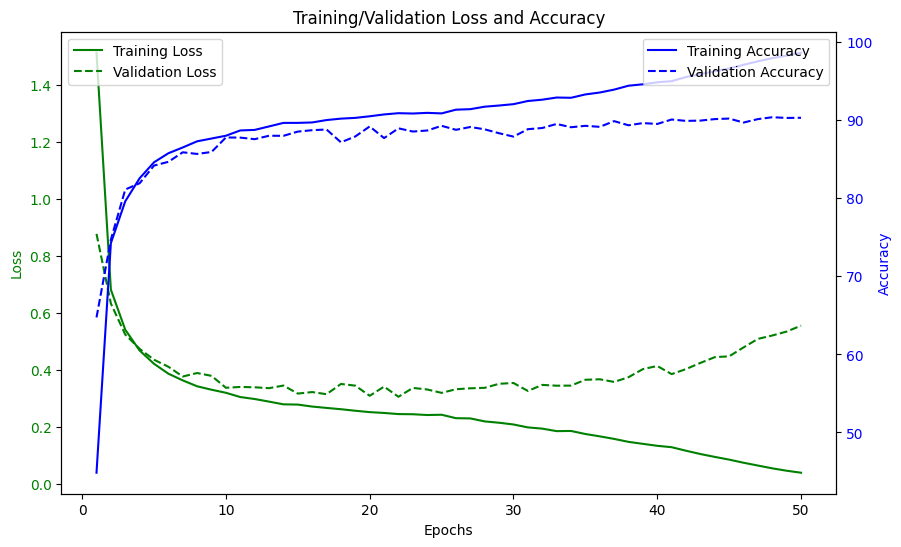

In [ ]:
import matplotlib.pyplot as plt

epochs = [i+1 for i in range(NUM_EPOCHS)]

# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the first y-axis
ax1.plot(epochs, train_losses, 'g-', label='Training Loss')
ax1.plot(epochs, test_losses, 'g--', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create a second y-axis for the accuracy, sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
ax2.plot(epochs, test_acc, 'b--', label='Validation Accuracy')
ax2.set_ylabel('Accuracy', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Add a title
plt.title('Training/Validation Loss and Accuracy')

# Add legends
loss_legend = ax1.legend(loc='upper left')
acc_legend = ax2.legend(loc='upper right')



### 3.

In [ ]:
import math
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VanillaLeNet5().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()
batch_sizes = [2**i for i in range(5, 13)]  # 32 to 4096
losses = []
log2_batch_sizes = []
step_size = 4

for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model.train()
    total_loss = 0.0
    for epoch in range(step_size):  # Assuming a step size of 1 epoch for each batch size
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    avg_loss = total_loss / (len(train_loader) * step_size)
    losses.append(avg_loss)
    log2_batch_sizes.append(math.log2(batch_size))
    print(f"Batch Size: {batch_size}, Average Loss: {avg_loss}")


Batch Size: 32, Average Loss: 0.5004048738886913
Batch Size: 64, Average Loss: 0.2902267682574578
Batch Size: 128, Average Loss: 0.2481869611261623
Batch Size: 256, Average Loss: 0.22493223872115004
Batch Size: 512, Average Loss: 0.21077618310701543
Batch Size: 1024, Average Loss: 0.20279861235265004
Batch Size: 2048, Average Loss: 0.19858888338009517
Batch Size: 4096, Average Loss: 0.19649147217472393


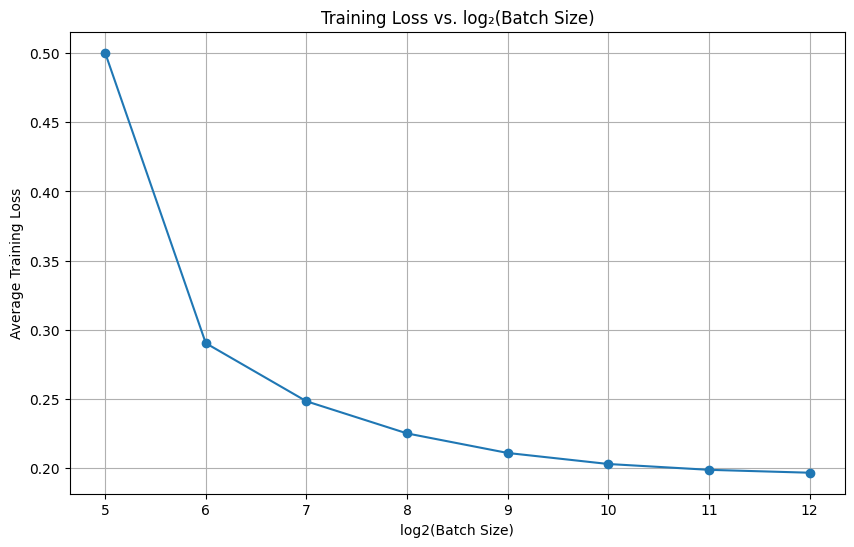

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(log2_batch_sizes, losses, marker='o', linestyle='-')
plt.xlabel('log2(Batch Size)')
plt.ylabel('Average Training Loss')
plt.title('Training Loss vs. log₂(Batch Size)')
plt.grid(True)
plt.show()

Training loss decreases when the batch size increases, and seems that the generalization ability of CLR is better than this one.